In [1]:
!nvidia-smi

Mon May 27 17:02:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow
print(tensorflow.__version__)

2.3.1


In [3]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [4]:

DATA_DIR = "../input/tiny-imagenet/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    X_train = []
    X_test = []
    
    # training set.
    for c in os.listdir("../input/tiny-imagenet/tiny-imagenet-200/train"):
        c_dir = os.path.join("../input/tiny-imagenet/tiny-imagenet-200/train", c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    return np.array(X_train)

In [5]:

X_train_orig = load_dataset_small()
X_train = X_train_orig/255.
#X_test = X_test_orig/255.


print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) 

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [6]:
# S1
input_S1 = X_train[0:X_train.shape[0] // 4]
# S2
input_S2 = X_train[X_train.shape[0] // 4 : 2*(X_train.shape[0] // 4)]
# S3
input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]




#cover
input_C = X_train[3*(X_train.shape[0] // 4):]

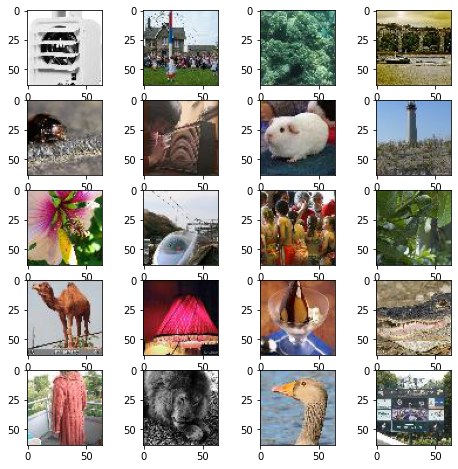

In [7]:

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [8]:
beta = 1.0    
def rev_loss(s_true, s_pred):
    print(s_true.shape, s_pred.shape)
    return beta * K.sum(K.square(s_true - s_pred))

def full_loss(y_true, y_pred):
    # Loss for the full model is:|C-C'|+beta*|S-S'|
    print(y_true.shape, y_pred.shape)
    s1_true, s2_true, s3_true, c_true = y_true[...,0:3], y_true[...,3:6], y_true[...,6:9], y_true[...,9:12]
    s1_pred, s2_pred, s3_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6], y_pred[...,6:9], y_pred[...,9:12]

    #s_loss = rev_loss(s_true, s_pred)
    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    s2_loss = beta * K.sum(K.square(s2_true - s2_pred))
    s3_loss = beta * K.sum(K.square(s3_true - s3_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s1_loss + c_loss + s2_loss + s3_loss

def make_encoder(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x1 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_S2)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_S2)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_S2)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x2 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_3')(input_S3)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_3')(input_S3)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_3')(input_S3)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_3')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_3')(x)
    x3_1 = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x1, x2, x3_1])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S1, input_S2, input_S3, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

def make_decoder1(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S1prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S1prime)

def make_decoder2(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_2')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_2')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_2')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    output_S2prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S2')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S2prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S2prime)

def make_decoder3(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S3prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S3')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,outputs=output_S3prime)
    else:
        #return Container(inputs=reveal_input,outputs=output_S2prime,name = 'DecoderFixed')
        return Network(inputs=reveal_input,outputs=output_S3prime)

# Full model.
def make_model(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder1 = make_decoder1(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss)
    decoder1.trainable = False

    decoder2 = make_decoder2(input_size)
    decoder2.compile(optimizer='adam', loss=rev_loss)
    decoder2.trainable = False

    decoder3 = make_decoder3(input_size)
    decoder3.compile(optimizer='adam', loss=rev_loss)
    decoder3.trainable = False
    
    output_Cprime = encoder([input_S1, input_S2, input_S3, input_C])
    output_S1prime = decoder1(output_Cprime)
    output_S2prime = decoder2(output_Cprime)
    output_S3prime = decoder3(output_Cprime)

    autoencoder1 = Model(inputs=[input_S1, input_S2, input_S3, input_C],
                        outputs=concatenate([output_S1prime, output_S2prime, output_S3prime, output_Cprime]))
    autoencoder1.compile(optimizer='adam', loss=full_loss)


    return encoder, decoder1, decoder2, decoder3, autoencoder1

In [9]:
encoder_model, reveal_model1, reveal_model2, reveal_model3, autoencoder_model = make_model(input_S1.shape[1:])

In [10]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [11]:
import time
NB_EPOCHS = 2
BATCH_SIZE = 256

m = input_S1.shape[0]
loss_history = []
start_time = time.time()
#loss_history2 = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    #ae_loss2 = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        #ae_loss2.append(autoencoder_model2.train_on_batch(x=[batch_S1, batch_S2, batch_C],
        #                                           y=np.concatenate((batch_S2, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        #K.set_value(autoencoder_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch))
    #autoencoder_model2.save_weights('models/model'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    #loss_history2.append(np.mean(ae_loss2))
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

(256, 64, 64, 12) (256, 64, 64, 12)
(256, 64, 64, 12) (256, 64, 64, 12)
(256, 64, 64, 3) (256, 64, 64, 3)
(256, 64, 64, 3) (256, 64, 64, 3)
(256, 64, 64, 3) (256, 64, 64, 3)
(256, 64, 64, 3) (256, 64, 64, 3)
(256, 64, 64, 3) (256, 64, 64, 3)
(256, 64, 64, 3) (256, 64, 64, 3)


Epoch 1 | Batch:   0 of 500. Loss AE 3432207.50 | Loss Rev1  835762.25 | Loss Rev2  894225.44 | Loss Rev3  882002.69:  50%|█████     | 1/2 [00:16<00:16, 16.12s/it]

(244, 64, 64, 12) (244, 64, 64, 12)
(244, 64, 64, 3) (244, 64, 64, 3)
(244, 64, 64, 3) (244, 64, 64, 3)
(244, 64, 64, 3) (244, 64, 64, 3)


Epoch 1 | Batch: 256 of 500. Loss AE 4045952.75 | Loss Rev1  922056.16 | Loss Rev2 1020437.53 | Loss Rev3 1255512.78: 100%|██████████| 2/2 [00:26<00:00, 13.24s/it]
Epoch 2 | Batch: 256 of 500. Loss AE 3009716.62 | Loss Rev1  737698.94 | Loss Rev2  793152.91 | Loss Rev3  782155.16: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]


Total training time: 34.01 seconds


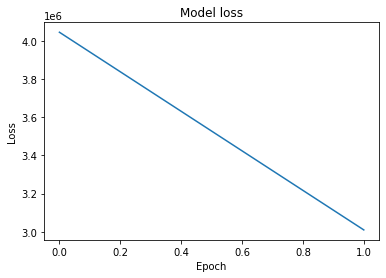

In [12]:
1# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [13]:
for epoch in range(10):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 256 of 500. Loss AE 2615401.38 | Loss Rev1  651291.81 | Loss Rev2  661341.50 | Loss Rev3  624620.12: 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]
Epoch 2 | Batch: 256 of 500. Loss AE 1513358.94 | Loss Rev1  313835.92 | Loss Rev2  375738.67 | Loss Rev3  353131.11: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]
Epoch 3 | Batch: 256 of 500. Loss AE 1119279.06 | Loss Rev1  269148.44 | Loss Rev2  273869.94 | Loss Rev3  224096.80: 100%|██████████| 2/2 [00:06<00:00,  3.50s/it]
Epoch 4 | Batch: 256 of 500. Loss AE  975479.00 | Loss Rev1  237395.02 | Loss Rev2  252235.10 | Loss Rev3  208978.23: 100%|██████████| 2/2 [00:07<00:00,  3.50s/it]
Epoch 5 | Batch: 256 of 500. Loss AE  942083.97 | Loss Rev1  247259.96 | Loss Rev2  235769.16 | Loss Rev3  197145.84: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]
Epoch 6 | Batch: 256 of 500. Loss AE  902652.50 | Loss Rev1  238192.66 | Loss Rev2  228202.80 | Loss Rev3  199086.10: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]
Epoch 7 | Batch:

In [14]:
for epoch in range(50):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 256 of 500. Loss AE  838494.44 | Loss Rev1  219526.15 | Loss Rev2  217537.31 | Loss Rev3  223933.53: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]
Epoch 2 | Batch: 256 of 500. Loss AE  815664.97 | Loss Rev1  209365.34 | Loss Rev2  210126.98 | Loss Rev3  218415.63: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]
Epoch 3 | Batch: 256 of 500. Loss AE  808073.00 | Loss Rev1  208182.95 | Loss Rev2  212609.33 | Loss Rev3  205005.72: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]
Epoch 4 | Batch: 256 of 500. Loss AE  802046.12 | Loss Rev1  210764.30 | Loss Rev2  210225.61 | Loss Rev3  199954.30: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]
Epoch 5 | Batch: 256 of 500. Loss AE  800389.91 | Loss Rev1  203756.98 | Loss Rev2  214022.12 | Loss Rev3  199184.02: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]
Epoch 6 | Batch: 256 of 500. Loss AE  809869.19 | Loss Rev1  210961.80 | Loss Rev2  217273.41 | Loss Rev3  195866.31: 100%|██████████| 2/2 [00:06<00:00,  3.49s/it]
Epoch 7 | Batch:

In [15]:
for epoch in range(400):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 256 of 500. Loss AE  481476.70 | Loss Rev1   90808.89 | Loss Rev2  156920.98 | Loss Rev3   85993.71: 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]
Epoch 2 | Batch: 256 of 500. Loss AE  473959.03 | Loss Rev1   88722.24 | Loss Rev2  159217.35 | Loss Rev3   83541.06: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]
Epoch 3 | Batch: 256 of 500. Loss AE  470762.67 | Loss Rev1   88435.76 | Loss Rev2  160377.46 | Loss Rev3   82656.41: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]
Epoch 4 | Batch: 256 of 500. Loss AE  457345.22 | Loss Rev1   82199.18 | Loss Rev2  153082.78 | Loss Rev3   81307.33: 100%|██████████| 2/2 [00:06<00:00,  3.48s/it]
Epoch 5 | Batch: 256 of 500. Loss AE  451370.81 | Loss Rev1   80227.52 | Loss Rev2  148564.35 | Loss Rev3   79464.46: 100%|██████████| 2/2 [00:07<00:00,  3.51s/it]
Epoch 6 | Batch: 256 of 500. Loss AE  448165.41 | Loss Rev1   79546.66 | Loss Rev2  147717.59 | Loss Rev3   80151.96: 100%|██████████| 2/2 [00:06<00:00,  3.45s/it]
Epoch 7 | Batch:

In [16]:
autoencoder_model.load_weights('models/model3_28')

In [17]:
BATCH_SIZE = 32
for epoch in range(100):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model_A21_'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/16 [00:00<?, ?it/s]

(None, 64, 64, 12) (None, 64, 64, 12)
(None, 64, 64, 3) (None, 64, 64, 3)
(None, 64, 64, 3) (None, 64, 64, 3)
(None, 64, 64, 3) (None, 64, 64, 3)


Epoch 1 | Batch: 480 of 500. Loss AE   52229.42 | Loss Rev    8529.58 | Loss Rev2   19453.51 | Loss Rev3   11436.19: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]
Epoch 2 | Batch: 480 of 500. Loss AE   47258.48 | Loss Rev    8397.77 | Loss Rev2   17204.47 | Loss Rev3    9494.36: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]
Epoch 3 | Batch: 480 of 500. Loss AE   45510.24 | Loss Rev    8368.47 | Loss Rev2   16312.46 | Loss Rev3    9181.91: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]
Epoch 4 | Batch: 480 of 500. Loss AE   44034.09 | Loss Rev    8334.16 | Loss Rev2   15626.26 | Loss Rev3    8892.69: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]
Epoch 5 | Batch: 480 of 500. Loss AE   42567.97 | Loss Rev    8344.27 | Loss Rev2   14548.56 | Loss Rev3    8794.73: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
Epoch 6 | Batch: 480 of 500. Loss AE   41441.56 | Loss Rev    8253.91 | Loss Rev2   14001.20 | Loss Rev3    8473.42: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]
Epoch 7 | 

In [18]:
autoencoder_model.load_weights('/kaggle/working/models/model_A21_8')


In [19]:
decoded = autoencoder_model.predict([input_S1, input_S2, input_S3, input_C])
decoded_S1, decoded_S2, decoded_S3, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9], decoded[...,9:12]

diff_S1, diff_S2, diff_S3, diff_C = np.abs(decoded_S1 - input_S1), np.abs(decoded_S2 - input_S2), np.abs(decoded_S3 - input_S3), np.abs(decoded_C - input_C) 

In [20]:
def pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C):
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))
    see_S2pixel = np.sqrt(np.mean(np.square(255*(input_S2 - decoded_S2))))
    see_S3pixel = np.sqrt(np.mean(np.square(255*(input_S3 - decoded_S3))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_S1pixel, see_S2pixel, see_S3pixel, see_Cpixel
def pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C):
    diff_S1flat = diff_S1.flatten()
    diff_S2flat = diff_S2.flatten()
    diff_S3flat = diff_S3.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 10))  
    
    # Add first subplot
    a = fig.add_subplot(2,2,1)
    imgplot = plt.hist(255 * diff_Cflat, bins=100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    # Add second subplot
    a = fig.add_subplot(2,2,2)
    imgplot = plt.hist(255 * diff_S1flat, bins=100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    # Add third subplot
    a = fig.add_subplot(2,2,3)
    imgplot = plt.hist(255 * diff_S2flat, bins=100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image2.')
    plt.axis([0, 250, 0, 0.2])

    # Add fourth subplot
    a = fig.add_subplot(2,2,4)
    imgplot = plt.hist(255 * diff_S3flat, bins=100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()


In [21]:
# Print pixel-wise average errors in a 256 scale.
S1_error, S2_error, S3_error, C_error = pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C)

print ("S1 error per pixel [0, 255]:", S1_error)
print ("S2 error per pixel [0, 255]:", S2_error)
print ("S2 error per pixel [0, 255]:", S3_error)
print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 36.303436
S2 error per pixel [0, 255]: 46.23739
S2 error per pixel [0, 255]: 37.18072
C error per pixel [0, 255]: 41.024734


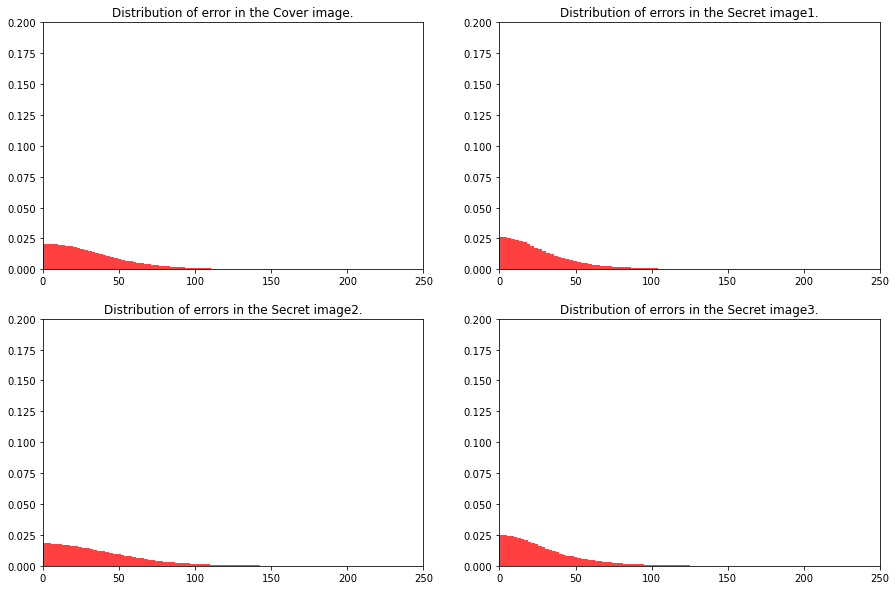

In [22]:
# Plot
pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C)

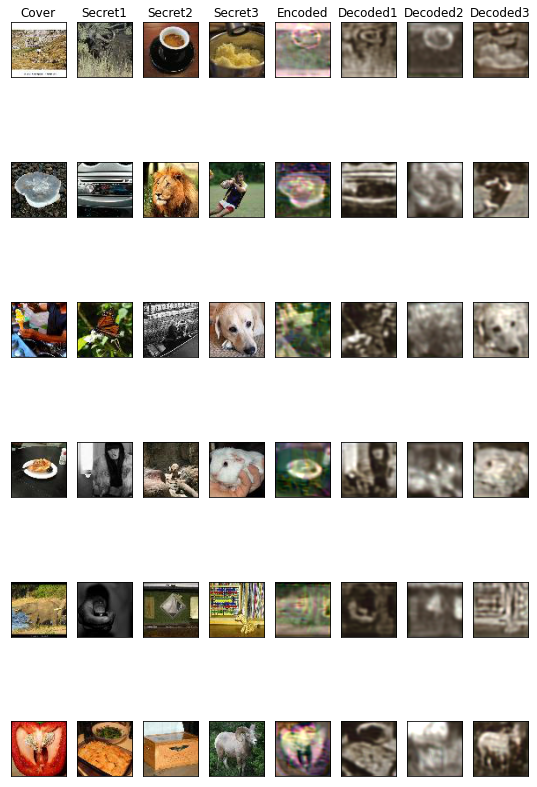

In [23]:
SHOW_GRAY = False
SHOW_DIFF = True
ENHANCE = 1
n = 6
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 500) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret1')

    show_image(input_S2[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Secret2')

    show_image(input_S3[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Secret3')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Encoded')
    
    show_image(decoded_S1[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded1')

    show_image(decoded_S2[idx], n, n_col, i * n_col + 7, gray=SHOW_GRAY, first_row=i==0, title='Decoded2')

    show_image(decoded_S3[idx], n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Decoded3')

plt.show()

In [24]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Calculate PSNR for cover and secret images
psnr_c = peak_signal_noise_ratio(input_C, decoded_C, data_range=255)
psnr_s1 = peak_signal_noise_ratio(input_S1, decoded_S1, data_range=255)
psnr_s2 = peak_signal_noise_ratio(input_S2, decoded_S2, data_range=255)
psnr_s3 = peak_signal_noise_ratio(input_S3, decoded_S3, data_range=255)

print(f"PSNR for Cover Image: {psnr_c:.2f} dB")
print(f"PSNR for Secret Image 1: {psnr_s1:.2f} dB")
print(f"PSNR for Secret Image 2: {psnr_s2:.2f} dB")
print(f"PSNR for Secret Image 3: {psnr_s3:.2f} dB")

# Calculate SSIM for cover and secret images
ssim_c = structural_similarity(input_C, decoded_C, data_range=255, multichannel=True)
ssim_s1 = structural_similarity(input_S1, decoded_S1, data_range=255, multichannel=True)
ssim_s2 = structural_similarity(input_S2, decoded_S2, data_range=255, multichannel=True)
ssim_s3 = structural_similarity(input_S3, decoded_S3, data_range=255, multichannel=True)

print(f"SSIM for Cover Image: {ssim_c:.4f}")
print(f"SSIM for Secret Image 1: {ssim_s1:.4f}")
print(f"SSIM for Secret Image 2: {ssim_s2:.4f}")
print(f"SSIM for Secret Image 3: {ssim_s3:.4f}")

PSNR for Cover Image: 64.00 dB
PSNR for Secret Image 1: 65.06 dB
PSNR for Secret Image 2: 62.96 dB
PSNR for Secret Image 3: 64.86 dB
SSIM for Cover Image: 0.9993
SSIM for Secret Image 1: 0.9995
SSIM for Secret Image 2: 0.9990
SSIM for Secret Image 3: 0.9994
